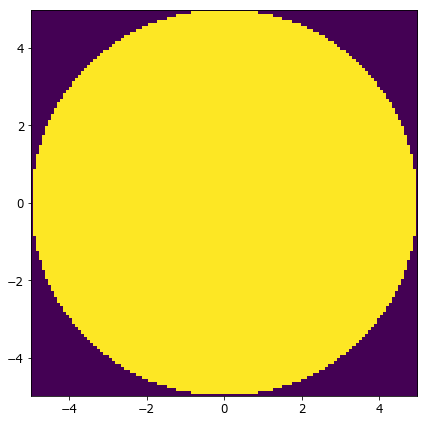

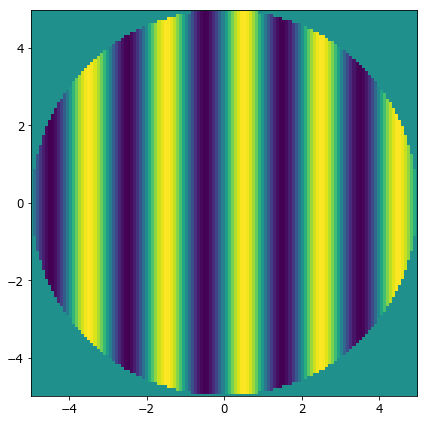

In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

N = 128
D = 9.96
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
wf = Wavefront(aperture(pupil_grid))

aberrated = wf.copy()
amplitude = 0.3
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D * spatial_frequency))

imshow_field(wf.intensity)
plt.show()
imshow_field(aberrated.phase)
plt.show()

In [2]:
aberration_mode_basis = []
for i in range(N):
    for j in range(N):
        wf = Wavefront(aperture(pupil_grid))
        wf.electric_field.shape = (N, N)
        l = wf.electric_field.tolist()
        if np.real(l[i][j]) > 0:
            l[i][j] = 0
            wf.electric_field = Field(np.asarray(l).ravel(), wf.grid)
            aberration_mode_basis.append(wf)
print(len(aberration_mode_basis))

12644


In [3]:
flat_mode = Wavefront(aperture(pupil_grid))

In [4]:
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=65/39.3, num_pupil_pixels=40)
pyramid_output_basis = []
for index, x in enumerate(aberration_mode_basis):
    pyramid_output_basis.append(keck_pyramid.forward(x))
# This is a long process, takes about 4 seconds to get through 100. So it's about 8.5 mins.    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [5]:
flat_pyramid_output = keck_pyramid.forward(flat_mode)

In [8]:
def new_get_sub_images(intensity):
    buffer = 0
    sps = 40
    pyramid_grid = make_pupil_grid(N, 3.6e-3)
    images = Field(np.asarray(intensity).ravel(), pyramid_grid)
    images.shape = (107, 107)
    image = images

    sub_images = [image[66:106, 66:106],
                  image[66:106, 0:40],
                  image[0:40, 0:40],
                  image[0:40, 66:106]]
    subimage_grid = make_pupil_grid(sps)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

# indexing starts from the bottom left

In [9]:
new_get_sub_images(pyramid_output_basis[0].intensity)

[Field([ 0.09519276,  0.1077058 ,  0.10867247, ...,  0.08623607,
         0.07849565,  0.073353  ]),
 Field([ 0.07209439,  0.08036521,  0.08243927, ...,  0.08274847,
         0.08239295,  0.08460654]),
 Field([ 0.05383754,  0.05957864,  0.06187748, ...,  0.14568071,
         0.13668568,  0.13101028]),
 Field([ 0.07209443,  0.0810772 ,  0.08267802, ...,  0.08410168,
         0.08387291,  0.08460749])]

In [10]:
sub_images_basis = []
for index, x in enumerate(pyramid_output_basis):
    if index % 100 == 0:
        print(index)
    sub_images_basis.append(new_get_sub_images(x.intensity))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600


In [11]:
print(len(sub_images_basis))
print(len(sub_images_basis[0]))
print(sub_images_basis[0][1].shape)

12644
4
(1600,)


In [12]:
def estimate(EstimatorObject, images_list):
    '''
    Slightly edited version of the PWFSEstimator.estimate function. The earlier function had a difference in sub-pupil
    numbering compared to the literature I found. As implemented before, it was 
    a b
    c d
    but according to papers such as https://ui.adsabs.harvard.edu/#abs/2006OExpr..1411925B/abstract (page 3) it's
    b a
    c d
    '''
    I_a = images_list[0]
    I_b = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = Field(np.zeros(I_x.size), I_x.grid)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    dummy = dummy.ravel()
    # previously, was not possible to plot res, can now do so as a red-green plot (red = x and green = y).
    return [I_x, I_y]

In [13]:
sps = 40
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, (3.6e-3)*sps*2/N))
estimated_basis = []
for index, x in enumerate(sub_images_basis):
    if index % 1000 == 0:
        print(index)
    estimated_basis.append(estimate(keck_pyramid_estimator, x))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [17]:
flat_x, flat_y = estimate(keck_pyramid_estimator, new_get_sub_images(flat_pyramid_output.intensity))

In [63]:
Wavefront(aperture(pupil_grid)).intensity.size

16384

In [16]:
wf = Wavefront(aperture(pupil_grid))
def make_matrix_from_wf(wf):
    return wf.phase[aperture(pupil_grid) > 0] #size should be 12644 for N = 128

aberrated = wf.copy()
amplitude = 1
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D * spatial_frequency))
matrix_aberrated = make_matrix_from_wf(aberrated)

In [ ]:
'''tolerance = 0.05
imshow_field(aberrated.phase, vmin=1-tolerance, vmax=1)
plt.show()
not_one = matrix_aberrated[abs(1 - matrix_aberrated) > tolerance]
print(matrix_aberrated.size - not_one.size)''' 
def makeflatwfslopes():
    outgrid = np.zeros((N, N)).tolist()
    pyramid_output.shape = (outgrid_size, outgrid_size)
    buffer = (N - outgrid_size)//2
    flat_pyramid_output = keck_pyramid.forward(wf).intensity
    flat_pyramid_output.shape = (outgrid_size, outgrid_size)
    # added ability to get sub-pupil images that are separated. Default PWFSOptics has pupil separation = 1.5 but 
    # image extraction assumes separation = 1. Not sure, but this may have caused errors before.
    for rownum, row in enumerate(flat_pyramid_output.tolist()):
        for colnum, el in enumerate(row):
            outgrid[rownum+buffer][colnum+buffer] = el
    images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
    image = images.shaped
    flat_sub_images = [image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)],
                  image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
                  image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
                  image[buffer:sps+buffer, buffer:sps+buffer]]
    '''sub_images = [image[66:106, 66:106],
                  image[66:106, 0:40],
                  image[0:40, 0:40],
                  image[0:40, 66:106]]'''
    for count, img in enumerate(flat_sub_images):
        img = img.ravel()
        img.grid = make_pupil_grid(sps)
        flat_sub_images[count] = img
    return estimate(keck_pyramid_estimator, flat_sub_images)

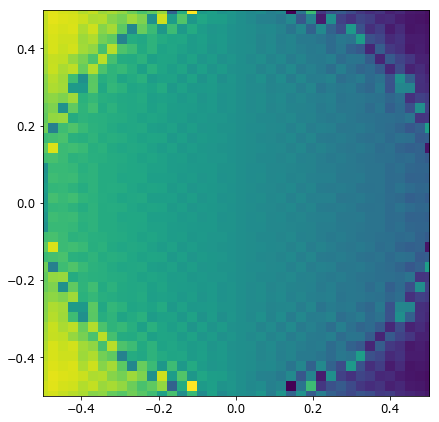

In [20]:
sps = 40 #sub-pupil size
pupsep = 65/39.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity

imshow_field(flat_y)
plt.show()

In [21]:
estimated_basis = [[x - flat_x, y - flat_y] for x, y in estimated_basis]

In [47]:
def get_slopes(num, range=0.01):
    plt.subplot(2,2,1)
    imshow_field(estimated_basis[num][0], vmin=-range, vmax=range)
    plt.colorbar()
    plt.subplot(2,2,2)
    imshow_field(estimated_basis[num][1], vmin=-range, vmax=range)
    plt.colorbar()
    plt.show()
    
for b in range(0, 12643, 1000):
    get_slopes(b)
    

TypeError: 'float' object is not callable

In [48]:
print(estimated_basis)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [50]:
estimated_basis_list = [x.tolist() for x in estimated_basis]


AttributeError: 'list' object has no attribute 'tolist'

In [52]:
print(type(estimated_basis[0][0]))

<class 'hcipy.field.field.Field'>


In [53]:
estimated_basis_list = [[x.tolist(), y.tolist()] for x, y in estimated_basis]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [55]:
print(len(estimated_basis_list))

12644
